In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# get gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [ ]:
# download CIFAR training data 
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# download CIFAR test data
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
batch_size = 64

# create respective dataloaders from datasets
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
class Vae(nn.Module):
  def __init__(self, n_latent):
    super(Vae, self).__init__()
    self.flatten = nn.Flatten()
    self.encoder = nn.Sequential(
        nn.Linear(32*32*3, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, n_latent),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(n_latent, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 32*32*3),
        nn.Sigmoid()
    )

  def forward(self, image):
    image = self.flatten(image)
    z = self.encoder(image)
    recon_image = self.decoder(z)

    return recon_image

In [ ]:
class SparseVae(nn.Module):
  def __init__(self, n_latent):
    super(SparseVae, self).__init__()
    self.flatten = nn.Flatten()
    self.enc1 = nn.Linear(32*32*3, 512)
    self.enc2 = nn.Linear(512, 512)
    self.enc3 = nn.Linear(512, n_latent)
    self.dec1 = nn.Linear(n_latent, 512)
    self.dec2 = nn.Linear(512, 512)
    self.dec3 = nn.Linear(512, 32*32*3)


  def forward(self, image):
    input = self.flatten(image)

    # loop through all fully connected layers of network and apply relu
    outputs = []
    for layer in self.children():
      if isinstance(layer, nn.Linear) and layer != self.dec3:
        outputs.append(F.relu(layer(input)))
        input = outputs[-1]
    
    # sigmoid non linearity for last layer
    outputs.append(torch.sigmoid(self.dec3(input)))

    return outputs


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=396aa02b0492d7ed99b418d3ff15584e6dec9b46df9ef6c58dccdaff53d36673
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


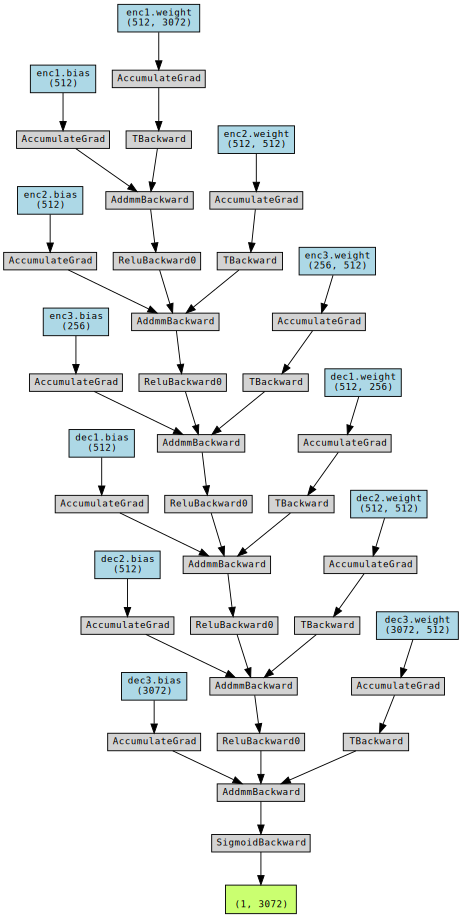

In [ ]:
x = train_data[0][0].unsqueeze(0).to(device)
m = SparseVae(256).to(device)
outputs = m(x)

from torchviz import make_dot
make_dot(outputs[-1], dict(list(m.named_parameters())))

In [ ]:
def kl_divergence(target_mean, activations):
  target_means = torch.full((activations.size()[1],), target_mean)
  activations = torch.clamp(activations, 0, 1)  # clip values
  mean_activations = torch.mean(activations, 0)
  kl = target_means * torch.log(target_means / mean_activations)
  kl += (1 - target_means) * torch.log((1 - target_means) / (1 - mean_activations))
  return torch.sum(kl).item()


In [ ]:
def l1(activations):
  return sum([torch.linalg.matrix_norm(activ) for activ in activations])


In [ ]:
def customLoss(outputs, targets):
  batch_size = outputs.size()[0]
  targets = nn.Flatten(1)(targets) # unroll 
  return ((outputs - targets) ** 2).sum() / batch_size

In [ ]:
# training loop
def train(trainloader, model, loss_fn, optimizer, sparse, verbose):
  size = len(trainloader.dataset)
  num_batches = len(trainloader)
  train_loss, count = 0.0, 0
  model.train()

  for batch, (X, _) in enumerate(trainloader):
    X = X.to(device)
    # forward pass
    outputs = model(X)
    loss = loss_fn(outputs[-1], X)
    if sparse:
      sparse_loss = l1(outputs)
      loss +=  sparse * sparse_loss
    train_loss += loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if verbose: 
      if batch % 200 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
  
  return train_loss / num_batches


# val loop
def val(valloader, model, loss_fn, verbose):
  size = len(valloader.dataset)
  num_batches = len(valloader)
  val_loss = 0.0
  model.eval()

  with torch.no_grad():
    for (X, _) in valloader:
      X = X.to(device)
      outputs = model(X)
      loss = loss_fn(outputs[-1], X)
      val_loss += loss.item()
  
  val_loss /= num_batches

  if verbose:
    print(f"Avg Val Loss: {val_loss:>8f}\n")

  return val_loss

In [ ]:
# train and validate model
def fit(model, optimizer, trainloader, valloader, 
                epochs=10, sparse=None, verbose=False):
  
  metrics = {'train_loss': [],
            'val_loss': [],
            }
  loss_fn = customLoss

  for epoch in range(epochs):
    if verbose:
      print(f"Epoch {epoch+1}\n{('-'*30)}")
      
    train_loss = train(trainloader, model, loss_fn, optimizer, sparse, verbose)
    val_loss = val(valloader, model, loss_fn, verbose)

    metrics['train_loss'].append(train_loss)
    metrics['val_loss'].append(val_loss)

    if not verbose:
      print(f"\rEpoch {epoch+1}: Train Loss {train_loss:0>5.3f} | "
            f"Val Loss {val_loss:0>5.3f}", end=''
           )
    
  print("\nDone!")

  return metrics

In [ ]:
epochs = 30
model = SparseVae(256).to(device)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.0005,
                            weight_decay=0,
                            momentum=0.9
)
metrics = fit(model, 
              optimizer,
              train_dataloader,
              val_dataloader,
              epochs,
              sparse=None,
              verbose=False
              )

Epoch 30: Train Loss 41.046 | Val Loss 41.127
Done!


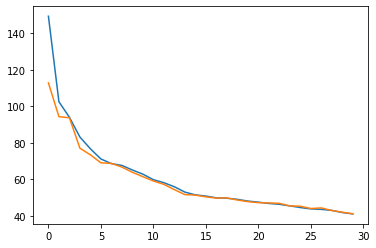

In [ ]:
plt.plot(metrics['train_loss'])
plt.plot(metrics['val_loss'])

In [ ]:
epochs = 30
sparse_model = SparseVae(256).to(device)
optimizer = torch.optim.SGD(sparse_model.parameters(),
                            lr=0.0005,
                            weight_decay=0,
                            momentum=0.9
)
sparse_metrics = fit(sparse_model, 
              optimizer,
              train_dataloader,
              val_dataloader,
              epochs,
              sparse=0.01,
              verbose=True
              )

Epoch 1
------------------------------
Loss: 199.398499 [    0/50000]
Loss: 183.076767 [12800/50000]
Loss: 181.594910 [25600/50000]
Loss: 187.865829 [38400/50000]
Avg Val Loss: 189.789036

Epoch 2
------------------------------
Loss: 198.818649 [    0/50000]
Loss: 187.524567 [12800/50000]
Loss: 174.548767 [25600/50000]
Loss: 198.394928 [38400/50000]
Avg Val Loss: 176.143544

Epoch 3
------------------------------
Loss: 162.380722 [    0/50000]
Loss: 169.723083 [12800/50000]
Loss: 156.927139 [25600/50000]
Loss: 143.879562 [38400/50000]
Avg Val Loss: 125.715251

Epoch 4
------------------------------
Loss: 125.248215 [    0/50000]
Loss: 109.718315 [12800/50000]
Loss: 115.726753 [25600/50000]
Loss: 133.537735 [38400/50000]
Avg Val Loss: 117.383177

Epoch 5
------------------------------
Loss: 126.021194 [    0/50000]
Loss: 102.542702 [12800/50000]
Loss: 126.871841 [25600/50000]
Loss: 123.648407 [38400/50000]
Avg Val Loss: 112.586921

Epoch 6
------------------------------
Loss: 117.256729

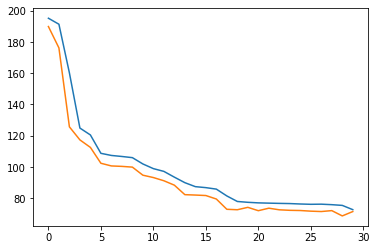

In [ ]:
plt.plot(sparse_metrics['train_loss'])
plt.plot(sparse_metrics['val_loss'])

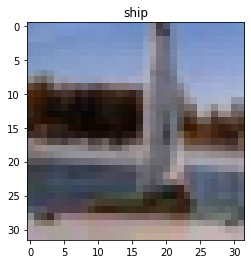

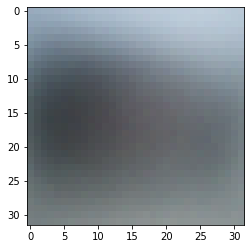

In [ ]:
model_output(sparse_model, train_data)

In [ ]:
epochs = 30
sparse_model = SparseVae(256).to(device)
optimizer = torch.optim.SGD(sparse_model.parameters(),
                            lr=0.0001,
                            weight_decay=0,
                            momentum=0.9
)
metrics = fit(sparse_model, 
              optimizer,
              train_dataloader,
              val_dataloader,
              epochs,
              sparse=0.01,
              verbose=True
              )

Epoch 1
------------------------------
Loss: 836.505371 [    0/50000]
Loss: 350.175720 [12800/50000]
Loss: 353.072052 [25600/50000]
Loss: 326.252411 [38400/50000]
Avg Val Loss: 281.637838

Epoch 2
------------------------------
Loss: 260.407196 [    0/50000]
Loss: 262.357361 [12800/50000]
Loss: 230.134720 [25600/50000]
Loss: 225.333832 [38400/50000]
Avg Val Loss: 212.526293

Epoch 3
------------------------------
Loss: 226.881668 [    0/50000]
Loss: 192.685242 [12800/50000]
Loss: 188.326172 [25600/50000]
Loss: 194.953430 [38400/50000]
Avg Val Loss: 174.065403

Epoch 4
------------------------------
Loss: 171.373154 [    0/50000]
Loss: 158.056015 [12800/50000]
Loss: 152.089706 [25600/50000]
Loss: 148.883316 [38400/50000]
Avg Val Loss: 145.053472

Epoch 5
------------------------------
Loss: 147.372604 [    0/50000]
Loss: 138.029694 [12800/50000]
Loss: 128.505341 [25600/50000]
Loss: 136.884369 [38400/50000]
Avg Val Loss: 131.109422

Epoch 6
------------------------------
Loss: 141.485992

In [ ]:
def model_output(model, train_data):
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')
  idx = np.random.choice(len(train_data))

  x, label = train_data[idx]
  plt.imshow(torch.moveaxis(x, 0, 2))
  plt.title(classes[label])
  plt.show()

  # model prediction
  outputs = model(x.unsqueeze(0).to(device))
  output = torch.reshape(outputs[-1].to('cpu'), (3, 32, 32)).detach()
  plt.imshow(torch.moveaxis(output, 0, 2))
  plt.show()



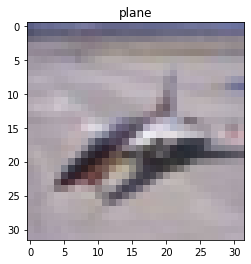

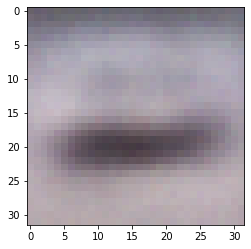

In [ ]:
model_output(model, train_data)

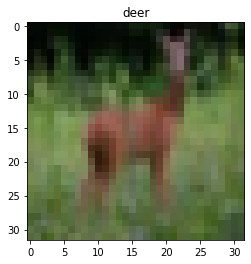

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


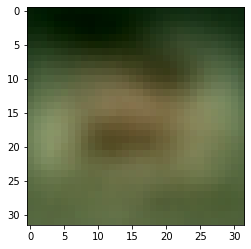

In [ ]:
model_output(model, test_data)

In [ ]:
epochs = 20
dmodel = Vae(128).to(device)
optimizer = torch.optim.SGD(dmodel.parameters(),
                            lr=0.0001,
                            weight_decay=0,
                            momentum=0.9
)
dmetrics = train_model(dmodel, 
                              optimizer,
                              train_dataloader,
                              test_dataloader,
                              epochs,
                              verbose=False
                              )

Epoch 20: Train Loss 38.369 | Test Loss 38.100
Done!


In [ ]:
ddmetrics = train_model(dmodel,
                        optimizer,
                        train_dataloader,
                        test_dataloader,
                        epochs,
                        verbose=False)

Epoch 20: Train Loss 30.756 | Test Loss 30.718
Done!


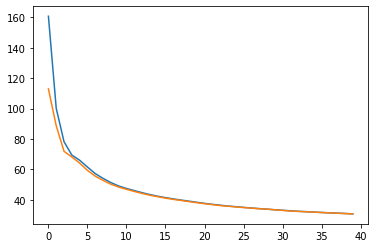

In [ ]:
plt.plot(dmetrics['train_loss'] + ddmetrics['train_loss'])
plt.plot(dmetrics['test_loss'] + ddmetrics['test_loss'])

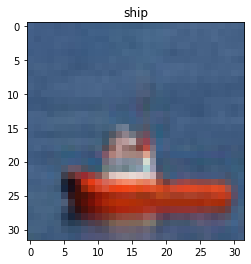

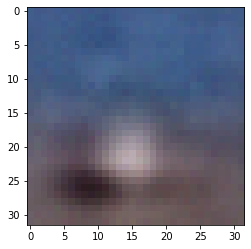

In [ ]:
model_output(dmodel, train_data)

In [ ]:
epochs = 50
bmodel = Vae(256).to(device)
optimizer = torch.optim.SGD(bmodel.parameters(),
                            lr=0.0001,
                            weight_decay=0,
                            momentum=0.9
)
bmetrics = train_model(bmodel, 
                              optimizer,
                              train_dataloader,
                              test_dataloader,
                              epochs,
                              verbose=False
                              )

Epoch 50: Train Loss 27.457 | Test Loss 27.373
Done!


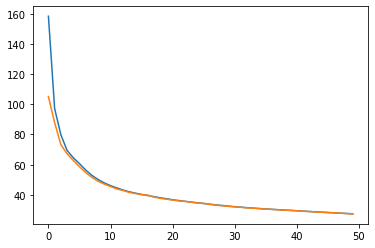

In [ ]:
plt.plot(bmetrics['train_loss'])
plt.plot(bmetrics['test_loss'])

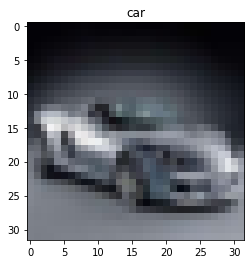

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


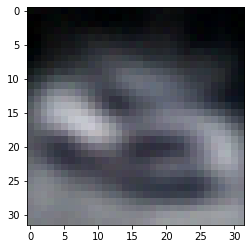

In [ ]:
model_output(bmodel, train_data)